# Model Performance

In [1]:
# load libraries
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

In [2]:
# instantiate
TODAY = dt.datetime.now()
nmr = yf.download('NMR-USD', start=TODAY, end=TODAY, progress=False)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

In [3]:
# get model performance history
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list)
    return df_all

# get model payout history
def get_model_payouts(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.round_model_performances(m))
        df["modelName"] = m
        df_list.append(df)
    df_all = pd.concat(df_list)
    payout_df = pd.pivot_table(
        df_all, 
        values='payout', 
        index=['roundOpenTime'], 
        columns=['modelName']).fillna(0)
    payout_df["totalPayout"] = payout_df.sum(axis=1)
    return payout_df

# plot model rankings
def plot_model_rankings(data, after_date, cols):
    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12, 8))
    df = data.loc[data["date"] >= after_date].set_index("date")
    df.loc[df["modelName"] == "dh_foxhound", cols].plot(ax=axes[0, 0])
    df.loc[df["modelName"] == "dh_deadcell", cols].plot(ax=axes[0, 1])
    df.loc[df["modelName"] == "dh_cobra", cols].plot(ax=axes[0, 2])
    df.loc[df["modelName"] == "dh_beautybeast", cols].plot(ax=axes[1, 0])
    df.loc[df["modelName"] == "dh_skulls", cols].plot(ax=axes[1, 1])
    df.loc[df["modelName"] == "dh_desperado", cols].plot(ax=axes[1, 2])
    axes[0, 0].set_title("Foxhound")
    axes[0, 1].set_title("Deadcell")
    axes[0, 2].set_title("Cobra")
    axes[1, 0].set_title("BeautyBeast")
    axes[1, 1].set_title("Skulls")
    axes[1, 2].set_title("Desperado")
    plt.show()

---
# Current Staking Amount

In [4]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[0]
nmr_price

11.733399152755737

In [5]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_desperado'])

In [6]:
# get current staking amount
nmr_stake_list = []
nmr_usd_list = []

for k in model_list:
    try:
        nmr_stake = round(float(napi.stake_get(k)), 2)
        nmr_usd = round(nmr_stake * nmr_price, 2)
        nmr_stake_list.append(nmr_stake)
        nmr_usd_list.append(nmr_usd)
    except:
        pass

pd.DataFrame({
    "model": model_list,
    "staked nmr": nmr_stake_list,
    "stked usd": nmr_usd_list
})

,model,staked nmr,stked usd
0,dh_foxhound,1.13,13.26
1,dh_deadcell,1.00,11.73
2,dh_cobra,0.99,11.62
3,dh_beautybeast,1.03,12.09
4,dh_skulls,0.00,0.00
5,dh_desperado,1.02,11.97


---
# Model Ranks

In [7]:
# get model rankings
perf = get_model_rankings(model_list=model_list)
perf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 461 entries, 0 to 29
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype                  
---  ------     --------------  -----                  
 0   corrRank   461 non-null    int64                  
 1   corrRep    461 non-null    float64                
 2   date       461 non-null    datetime64[ns, tzutc()]
 3   fncRank    461 non-null    int64                  
 4   fncRep     461 non-null    float64                
 5   fncV3Rank  169 non-null    float64                
 6   fncV3Rep   169 non-null    float64                
 7   mmcRank    461 non-null    int64                  
 8   mmcRep     461 non-null    float64                
 9   tcRank     254 non-null    float64                
 10  tcRep      254 non-null    float64                
 11  modelName  461 non-null    object                 
dtypes: datetime64[ns, tzutc()](1), float64(7), int64(3), object(1)
memory usage: 46.8+ KB


In [8]:
# date variable
AFTER_DATE = "2022-04-01"

In [9]:
# check model name list
perf["modelName"].unique()

array(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast',
       'dh_skulls', 'dh_desperado'], dtype=object)

In [10]:
# cols
tc_rank_cols = [col for col in perf.columns if col.endswith("Rank") and col.startswith("tc")]
tc_rep_cols = [col for col in perf.columns if col.endswith("Rep") and col.startswith("tc")]
nontc_rank_cols = [col for col in perf.columns if col.endswith("Rank") and not col.startswith("tc")]
nontc_rep_cols = [col for col in perf.columns if col.endswith("Rep") and not col.startswith("tc")]

tc_rank_cols, tc_rep_cols, nontc_rank_cols, nontc_rep_cols

(['tcRank'],
 ['tcRep'],
 ['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep'])

---
# CorrRank & CorrRep

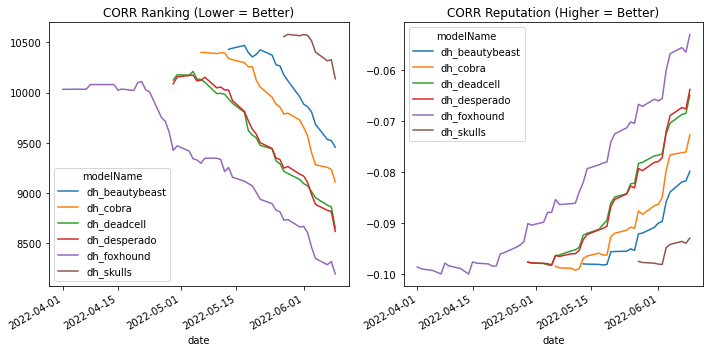

In [11]:
# plot  corr rank and rep
corrdf = perf.loc[perf["date"]>=AFTER_DATE]

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10, 5))
pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRank"]],
    values="corrRank",
    index="date",
    columns="modelName"
).plot(ax=axes[0])
axes[0].set_title("CORR Ranking (Lower = Better)")

pd.pivot_table(
    data=corrdf[["modelName", "date", "corrRep"]],
    values="corrRep",
    index="date",
    columns="modelName"
).plot(ax=axes[1])
axes[1].set_title("CORR Reputation (Higher = Better)")

plt.tight_layout()
plt.show()

---
# Ranks

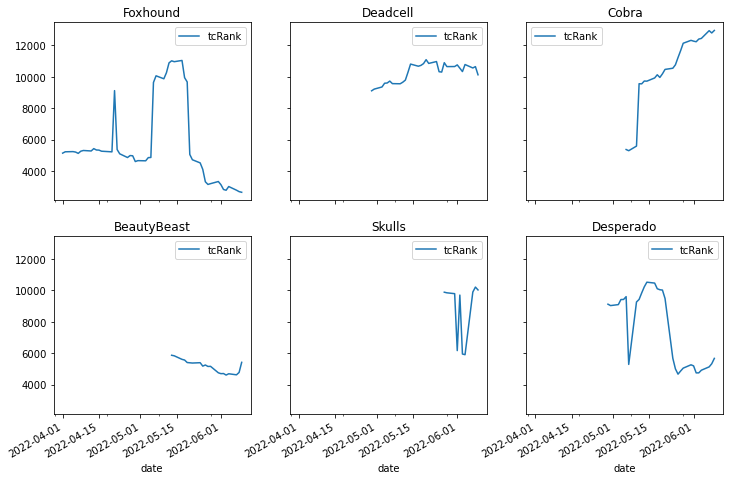

In [12]:
# plot rankings (TC)
plot_model_rankings(data=perf, after_date=AFTER_DATE, cols=tc_rank_cols)

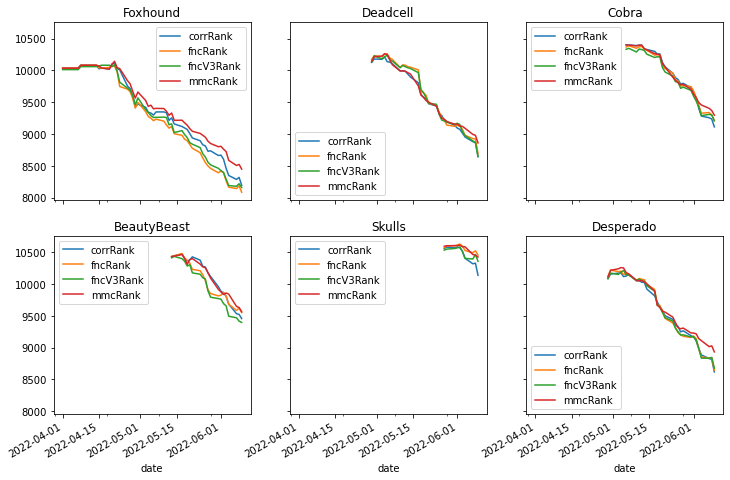

In [13]:
# plot rankings (non-TC)
plot_model_rankings(data=perf, after_date=AFTER_DATE, cols=nontc_rank_cols)

---
# Reputations

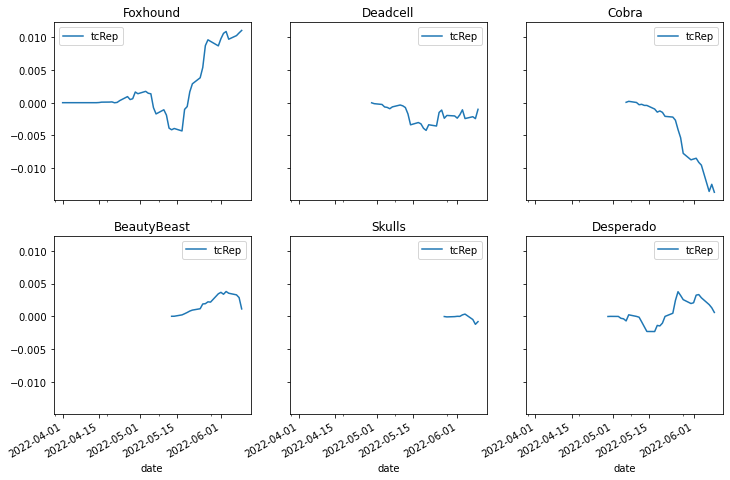

In [14]:
# plot reputations (TC)
plot_model_rankings(data=perf, after_date=AFTER_DATE, cols=tc_rep_cols)

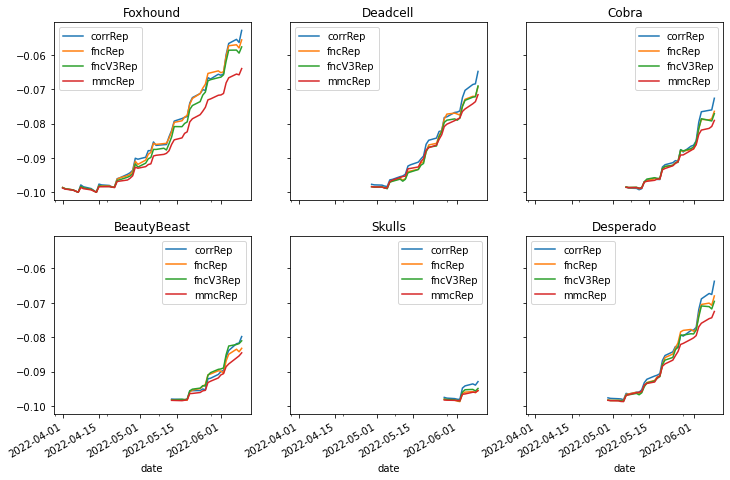

In [15]:
# plot reputations (non-TC)
plot_model_rankings(data=perf, after_date=AFTER_DATE, cols=nontc_rep_cols)

---
# Get model payouts

In [16]:
# get payout
payout = get_model_payouts(model_list)

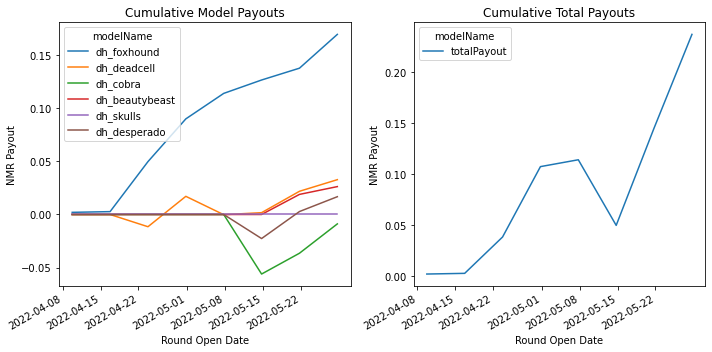

In [17]:
# plot payouts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
payout.loc[AFTER_DATE:][model_list].cumsum().plot(ax=axes[0])
payout.loc[AFTER_DATE:][["totalPayout"]].cumsum().plot(ax=axes[1])
axes[0].set_title("Cumulative Model Payouts")
axes[0].set_xlabel("Round Open Date")
axes[0].set_ylabel("NMR Payout")
axes[1].set_title("Cumulative Total Payouts")
axes[1].set_xlabel("Round Open Date")
axes[1].set_ylabel("NMR Payout")
plt.tight_layout()
plt.show()